#
### Python Preamble

In [1]:
# Analysis of Disulfide Bonds in Proteins of Known Structure 
# Author: Eric G. Suchanek, PhD.
# Last revision: 1/19/23 -egs-
# Cα Cβ Sγ

import math
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import plotly_express as px
#import seaborn as sns

import proteusPy
from proteusPy import *
from proteusPy.Disulfide import *
from proteusPy.ProteusGlobals import *

import pandas as pd
import pyvista as pv
from pyvista import set_plot_theme

#print(pv.Report())

plt.style.use('dark_background')

# ipyvtklink
# pv.set_jupyter_backend('ipyvtklink')

set_plot_theme('dark')

# the locations below represent the actual location on the dev drive.
# location for PDB repository
PDB_BASE = '/Users/egs/PDB/'

# location of cleaned PDB files
PDB = '/Users/egs/PDB/good/'

# location of the compressed Disulfide .pkl files
MODELS = f'{PDB_BASE}data/'


# Analysis of Disulfide Bonds in Proteins Within the RCSB Protein Data Bank
*Eric G. Suchanek, PhD. (suchanek@mac.com)* <br> <br>

## Summary
I describe the results of a structural analysis of Disulfide bonds contained in 35,819 proteins within the RCSB Protein databank, https://www.rcsb.org. These protein structures contained 120,697 Disulfide Bonds.  The analysis utilizes Python functions from my ``ProteusPy`` package https://github.com/suchanek/proteusPy/, which is built upon the excellent ``BioPython`` library (https://www.biopython.org). 

## Background
This work represents a reprise of my original Disulfide modeling analysis conducted in 1986 ([publications](#publications) item 1) as part of my doctoral dissertation. Given the original Disulfide database contained only 2xx Disulfide Bonds I felt it would be interesting to revisit the RCSB and mine the thousands of new structures. The analysis would not have been possible withoug the creation and now ongoing development of ```proteusPy```, which represents a true, modern object-oriented rewrite of my original ```proteus``` code base. The ```C``` implemntation still exists and is available at https://github.com/suchanek/proteus/.

The initial results are shown and described in the cells below.

## Intended Audience
This notebook is intended primarily for people interested in structural biophysics with an emphasis on the analysis of protein structures. As a result, it is fairly advanced. I have made an effort to describe the analysis plainly, but I assume the reader has a basic understanding of the elements of protein structure.

## Requirements
 - My Biopython fork or my delta applied, available at: https://github.com/suchanek/biopython/
 - proteusPy: https://github.com/suchanek/proteusPy/

## Introduction
Disulfide bonds are important covalent stabilizing elements in proteins, and function as intra-molecular cross-bridges. They are formed when two Sulphur-containing Cysteine (Cys) amino acid residues are close enough and in the correct geometry to form a S-S covalent bond with their terminal sidechain $S_\gamma$ atoms. The resulting residue is known as *Cystine*, or more commonly a *Disulfide* bond. This cross-bridge stabilizes the connected protein backbone via the alpha carbon, ($C_\alpha$) backbone atoms with this strong S-S covalent bond. This bond has high energy barriers to rotation, and as such has manifests partial double-bond character. Disulfide bonds most commonly occur between alpha helices and greatly enhance a protein's stability to denaturation. 


## Extract the Disulfides from the PDB files
The function ``Extract_Disulfides()`` processes all the .ent files in ``PDB_DIR`` and creates two .pkl files representing the Disulfide bonds contained in the scanned directory. In addition, a .csv file containing problem IDs is written if any are found. The .pkl files are consumed by the ``DisulfideLoader`` class and are considered private. You'll see numerous warnings during the scan. Files that are unparsable are removed and their IDs are logged to the problem_id.csv file. The default file locations are stored in the file globals.py and are the used by ``DisulfideExtractor()`` in the absence of arguments passed. The Disulfide parser is very stringent and will reject disulfide bonds with missing atoms or disordered atoms.


Outputs are saved in ``MODEL_DIR``:
1) ``SS_PICKLE_FILE``: The ``DisulfideList`` of ``Disulfide`` objects initialized from the PDB file scan, needed by the ``DisulfideLoader()`` class.
2) ``SS_DICT_PICKLE_FILE``: the ``Dict Disulfide`` objects also needed by the ``DisulfideLoader()`` class
3) ``PROBLEM_ID_FILE``: a .csv containining the problem ids.

In general, the process only needs to be run once for a full scan. Setting the ``numb`` argument to -1 scans the entire directory. Entering a positive number allows parsing a subset of the dataset, which is useful when debugging. Setting ``verbose`` enables verbose messages. Setting ``quiet`` to ``True`` disables all warnings.

NB: A extraction of the initial disulfide bond-containing files (> 36000 files) takes about 1.25 hours on a 2020 MacbookPro with M1 Pro chip, 16GB RAM, 1TB SSD. The resulting .pkl files consume approximately 1GB of disk space, and equivalent RAM used when loaded.

In [2]:


#Extract_Disulfides(numb=5000, pdbdir=PDB, datadir=MODELS, verbose=False, quiet=True)


## Load the Disulfide Data
Now that the Disulfides have been extracted and the Disulfide .pkl files have been created we can load them into memory using the DisulfideLoader() class. This class stores the Disulfides internally as a DisulfideList and a dict. Array indexing operations including slicing have been overloaded, enabling straightforward access to the Disulfide bonds, both in aggregate and by residue. After loading the .pkl files the Class creates a Pandas ``DataFrame`` object consisting of the Disulfide ID, all sidechain dihedral angles, the local coordinates for the Disulfide and the computed Disulfide bond torsional energy.

NB: Loading the data takes 3.5 minutes on my MacbookPro. Be patient if it seems to take a long time to load.

The ```Disulfide``` and ```DisulfideList``` classes include rendering capabiities using the excellent PyVista interface to the VTK package. (http://pyvista.org). The following cell displays the first Disulfide bond in the database in ball-and stick style. Atoms are colored by atom type:
- Grey = Carbon
- Blue = Nitrogen
- Red = Oxygen
- Yellow = Sulfur
- White = Previous residue carbonyl carbon and next residue amino Nitrogen. (more on this below).

We can load the database and display the first disulfide as shown below. The molecular display is *interactive*; select-drag to rotate, mousewheel to zoom. The X-Y-Z widget in the window upper right allows orientation against the X, Y and Z axes. The window title provides information about the disulfide rendered:
* Disulfide source ID
* Disulfide name, which embodies the source id, the proximal residue number and the distal residue number.
* Disulfide approximate torsional energy (kcal/mol)
* Disulfide $C_\alpha-C_\alpha$ distance $\AA$
* Disulfide torsion length (5-dimensional vector length) (degrees)

In [3]:
# default parameters will read from the package itself.
PDB_SS = DisulfideLoader(verbose=True, subset=True)


--> DisulfideLoader(): Reading disulfides from: /Users/egs/repos/proteusPy/proteusPy/data/PDB_subset_ss.pkl
--> DisulfideLoader(): Reading disulfide dict2 from: /Users/egs/repos/proteusPy/proteusPy/data/PDB_subset_ss_dict.pkl
--> DisulfideLoader(): Reading Torsion DF from: /Users/egs/repos/proteusPy/proteusPy/data/PDB_subset_torsions.csv.
Loading complete.
Summary: 
 PDB IDs parsed: 1000
 Disulfides loaded: 3393
 Total RAM Used by dataset: 0.82 GB.


In [ ]:
ss = PDB_SS[0]
ss.display(style='sb', light=True)

## Examine the Disulfide $C_\alpha-C_\alpha$ Distances

The disulfide bond maximum $C_\alpha-C_\alpha$ distance is constrained by the bond lengths and bond angles of the cystine (Cys-Cys) sidechain atoms. If the bond angles were linear the maximum possible $C_\alpha-C_\alpha$ distance would be 8.82 $\AA$. We can examine the database easily with Pandas to see this distance distribution.

In [5]:

# retrieve the torsions dataframe
from proteusPy.Disulfide import Torsion_DF_Cols

_SSdf = PDB_SS.getTorsions()

# there are a few structures with bad SSBonds. Their
# CA distances are > 7.0. We remove them from consideration
# below

_far = _SSdf['ca_distance'] >= 9.0
_near = _SSdf['ca_distance'] < 9.0

SS_df_Far = _SSdf[_far]

# entire database with near cutoff of 9.0
SS_df = _SSdf[_near]
SS_df = SS_df[Torsion_DF_Cols].copy()

SS_df_Far.describe()


,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.000000
mean,83.000000,125.500000,-68.646779,58.604960,126.648713,61.274894,-96.727940,7.839269,52.513174,-180.0,-180.0,-180.0,-180.0,212.861243
std,73.539105,109.601551,7.103029,35.283652,24.984061,100.973738,71.500414,1.526067,32.665715,0.0,0.0,0.0,0.0,34.687605
min,31.000000,48.000000,-73.669379,33.655650,108.982314,-10.124321,-147.286368,6.760177,29.415026,-180.0,-180.0,-180.0,-180.0,188.333403
25%,57.000000,86.750000,-71.158079,46.130305,117.815513,25.575286,-122.007154,7.299723,40.964100,-180.0,-180.0,-180.0,-180.0,200.597323
50%,83.000000,125.500000,-68.646779,58.604960,126.648713,61.274894,-96.727940,7.839269,52.513174,-180.0,-180.0,-180.0,-180.0,212.861243
75%,109.000000,164.250000,-66.135479,71.079615,135.481912,96.974501,-71.448727,8.378815,64.062249,-180.0,-180.0,-180.0,-180.0,225.125164
max,135.000000,203.000000,-63.624179,83.554270,144.315112,132.674109,-46.169513,8.918361,75.611323,-180.0,-180.0,-180.0,-180.0,237.389084


Initial analysis shown above reveals 145 physically impossible disulfides. These will be removed from consideration by rejecting disulfides whose $C_\alpha-C_\alpha$ distances are $> 9 \AA$. This should improve our overall protein structure data quality.


In [6]:
SS_df.describe()

,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,231.601592,280.147744,-49.122928,-15.660073,-3.804878,-31.964456,-35.857363,3.605300,5.526867,-98.443253,63.173192,-95.840510,62.551744,225.249558
std,292.361561,293.560504,95.483183,104.331908,93.867757,103.544915,95.282911,2.346482,0.776118,44.243856,99.120477,44.763353,97.081819,53.320883
min,1.000000,6.000000,-179.947368,-179.990782,-179.081812,-179.940602,-179.999305,0.494753,2.941898,-180.000000,-180.000000,-180.000000,-180.000000,116.478788
25%,48.000000,96.000000,-83.354005,-88.463182,-87.768273,-95.282036,-74.015239,1.936457,5.074306,-129.594372,-26.775539,-123.080531,-25.411530,181.923790
50%,136.000000,194.000000,-63.878076,-59.606547,-64.991519,-69.608413,-60.762262,3.134332,5.611413,-97.566453,112.923333,-97.915248,113.072762,225.617493
75%,311.000000,361.500000,-47.445764,82.069819,94.120634,69.443932,38.327723,4.435213,6.111800,-69.658749,143.797176,-70.473769,142.813820,263.008185
max,2592.000000,2599.000000,179.918814,179.987671,179.554652,179.977181,179.967868,17.289549,7.803253,177.021502,179.856474,178.886602,179.735964,368.022621



When we filter by distance, we see the average $C_\alpha-C_\alpha$ distance for the entire dataset is 5.52 $\AA$ , with a minimum distance of 2.83 $\AA$ and a maximum of 8.50 $\AA$. The 145 disulfides whose had distances >= 9 $\AA$ will be removed from consideration since they are not physically possible.

In [9]:
# The distances are in the SS_df dataframe and can be sorted easily
SS_df.sort_values(by=['ca_distance'], ascending=False, inplace=True)

SS_df.head(10)

,source,ss_id,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
3391,4qyz,4qyz_143A_250A,143,250,-69.050704,161.401761,-123.410979,-178.756423,170.219368,4.229833,7.803253,-65.493849,-49.756331,-75.614403,152.676285,327.073829
1952,2r92,2r92_67A_77A,67,77,-139.225150,-153.123911,-56.902218,-172.427826,163.559855,6.775726,7.712443,-171.729008,49.689713,-84.423706,104.042182,320.236816
2072,2pvc,2pvc_99A_118A,99,118,47.397018,104.453205,160.273091,132.376524,-87.161878,12.102695,7.610618,-121.490477,7.737748,-68.324059,135.024033,252.913325
546,5a7x,5a7x_331A_385A,331,385,-47.031456,109.281572,9.216346,-143.205095,-57.844963,11.603206,7.492839,-138.139919,146.101536,-95.934421,130.579415,195.174537
2071,2pvc,2pvc_56A_76A,56,76,60.773775,-100.979712,164.558371,116.169175,-91.595125,12.381598,7.308969,-105.324585,-11.532376,-81.684519,-44.419344,250.708507
2243,1n7d,1n7d_176A_188A,176,188,-150.946762,112.768721,105.409655,168.517287,52.950222,5.667654,7.271354,-169.822545,115.236690,-36.982472,163.646212,278.952875
2440,4fom,4fom_78A_148A,78,148,172.223331,-178.834634,-75.484443,-169.901092,-179.889958,0.928377,7.243607,-156.650280,122.339188,-102.252530,114.717098,358.562939
2687,7s15,7s15_85R_126R,85,126,69.799448,-164.188671,153.243415,168.394636,72.649443,7.262812,7.216113,-60.053707,143.408601,-99.243712,37.342834,298.241717
3092,7x42,7x42_23L_88L,23,88,76.327282,175.526326,147.918573,-175.084647,55.859689,6.485074,7.175685,-141.262412,146.964227,-113.482880,149.135307,303.793001
1974,7tnm,7tnm_718A_773A,718,773,-62.089726,-151.939500,175.785311,155.339919,-169.882777,8.885475,7.132873,41.939628,54.533863,-63.432431,134.362368,332.914208


We can extract and visualize the four longest structures and display them, as shown below. The individual windows display the disulfide bond in 'split-bond' style, where half of the bond is colored by the respective atom color. The window title indicates the approximate torsional energy (E kcal/mol), $C_\alpha-C_\alpha$ distance ($\AA$), and the torsion length (degrees). As is apparent, the $C_\beta-S_\gamma$ bond angles are almost linear. This suggests that the disulfide might not actually exist covalently, and could reflect errors in the original model.

In [ ]:
# extract and display the 4 longest SS bonds

i = 0
quattro = DisulfideList([], 'L4')

for i in range(4):
    ssid = SS_df.iloc[i]['ss_id']
    ss = PDB_SS.get_by_name(ssid)
    quattro.append(ss)

quattro.display(style='sb', light=True)

    

Plotting $C_\alpha-C_\alpha$ distances

In [10]:
#
labels = {'value': 'Cα Distance', 'variable': 'Count'}
cols = ['ca_distance']
data = SS_df[cols].copy()
#px.histogram(SS_df['ca_distance'], labels=labels, template='plotly_dark')
px.histogram(SS_df['ca_distance'], labels=labels)


## Examining Disulfide Energies
The approximate bond torsional energy (kcal/mol) of a given disulfide bond 
is calculated using the following equation: \n

$ E_{kcal/mol} \approx 2.0 * cos(3.0 * \chi_{1}) + cos(3.0 * \chi_{5}) + cos(3.0 * \chi_{2}) + $
$ cos(3.0 * \chi_{4}) + 3.5 * cos(2.0 * \chi_{3}) + 0.6 * cos(3.0 * \chi_{3}) + 10.1 $

The equation embodies the typical 3-fold rotation barriers associated with single bonds,
($\chi_1, \chi_5, \chi_2, \chi_4$) and a high 2-fold barrier for $\chi_3$, resulting from the partial double bond
character of the S-S bond. This property leads to two major disulfide families, characterized
by the sign of $\chi_3$. *Left-handed* disulfides have $\chi_3$ < 0° and *right-handed* disulfides have
$\chi_3$ > 0°.


In [11]:
labels = {'value': 'Energy', 'variable': 'Count'}
cols = ['energy']
#px.histogram(SS_df['energy'], labels=labels, histnorm='probability', template='plotly_dark')
px.histogram(SS_df['energy'], labels=labels, histnorm='probability')


### Find the lowest and highest energy disulfides and display them

In [12]:

All_SS_list = PDB_SS.SSList
ssMin, ssMax = PDB_SS.SSList.minmax_energy()
minmaxlist = DisulfideList([ssMin, ssMax], 'mm')
minmaxlist.display(style='bs', light=True)

ViewInteractiveWidget(height=512, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
minmaxlist.display_overlay(light=True)
ssMin.pprint()

100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.62it/s]


ViewInteractiveWidget(height=1024, layout=Layout(height='auto', width='100%'), width=1024)

<Disulfide 1xr9_203A_259A, Source: 1xr9, Resolution: 1.79 Å 
Conformation: (Χ1-Χ5):  -179.368°, 179.734°, -82.095°, -179.101° 179.295°  Energy: 0.495 kcal/mol 
Cα Distance: 6.364 Å 
Torsion length: 368.023 deg>


Very interesting result! Even though both disulfides span almost the exact same distance 5.5 $\AA$ vs 5.2 $\AA$ they do so with entirely different geometries. The minimum energy structure's torsion length of $145.62 \AA$ is significantly shorter than the maximum's $215.61 \AA$, despite the latter's *cis* $S_\gamma - S_\gamma$ bond. This *cis* conformation sits squarely on the disulfide's energy maximum, a fact reflected in the high 18.12 kcal/mol computed torsional energy.

On the other hand, *2q7q 75D-140D*, the lowest-energy disulfide is beautiful. Its conformation (-59.358°, -59.278°, -83.663°, -59.819° -59.914°) is only 7° from an overall global minimum ($\chi_3 = 90°$)

In [ ]:
ssMin.display(style='bs')

The structure above shows that the previous and next residues have missing atoms (the long vectors drawn).

In [14]:
SS_df = _SSdf[_near]
SS_df = SS_df[Torsion_DF_Cols]

SS_df = SS_df.sort_values(by=['energy'])
ssid_list = SS_df['ss_id'].values

good_SS_list = DisulfideList([],'l')
bad_SS_list = DisulfideList([],'h')

ss = Disulfide('tmp')

# first 12 are lowest energy
for i in range(12):
    ssid = ssid_list[i]
    ss = PDB_SS.get_by_name(ssid)
    good_SS_list.append(ss)
    
for i in range(13):
    if i == 0:
        continue
    ssid = ssid_list[-i]
    ss = PDB_SS.get_by_name(ssid)
    bad_SS_list.append(ss)
    


In [15]:
bad_SS_list.display_overlay(light=False)


100%|████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.74it/s]


ViewInteractiveWidget(height=1024, layout=Layout(height='auto', width='100%'), width=1024)

#bad_SS_list.display(style='sb')


In [16]:
labels = {'value': 'Distance', 'variable': 'Distance'}
cols = ['ca_distance', 'energy']
data = SS_df[cols].copy()
data.set_index('ca_distance')

px.histogram(SS_df, x='ca_distance', y='torsion_length', labels=labels, histfunc='avg', nbins=90, template='plotly_dark')


## Examine the Disulfide Torsions
The disulfide bond's overall conformation is defined by the sidechain dihedral angles $\chi_{1}$-$\chi_{5}$. Since the S-S bond has electron delocalization, it exhibits some double-bond character with strong minima at $+90°$ and $-90°$. The *Left-handed* Disulfides have $\chi_{3}$ < 0.0° and the *Right-handed* have a $\chi_{3}$ > 0.0°.

These torsion values along with the approximate torsional energy are stored in the DisulfideLoader() class and individually within each Disulfide object. We access them via the ``DisulfideList.getTorsions()`` function.

We can get a quick look at their overall statistics using the ``Pandas.describe()`` function.



In [17]:
labels = {'value': 'Angle', 'variable': 'Torsion'}

px.histogram(SS_df, x='chi1', y='chi5', labels=labels, nbins=90, histfunc='avg',
            template='plotly_dark')


In [18]:
labels = {'value': 'Angle', 'variable': 'Torsion'}

px.histogram(SS_df, x='chi2', y='chi4', labels=labels, nbins=90, histfunc='avg',
            template='plotly_dark')


### Examining torsions by Disulfide Handedness
We split the dataset into these two families easily with Pandas.

In [19]:
# make two dataframes containing left handed and right handed disulfides

_left = SS_df['chi3'] <= 0.0
_right = SS_df['chi3'] > 0.0

# left handed and right handed torsion dataframes
SS_df_Left = SS_df[_left]
SS_df_Right = SS_df[_right]

# routine creates 2 lists  for left-handed and right-handed disulfides 

ss_list = PDB_SS.SSList
left_handed_SS = DisulfideList([], 'left_handed')
right_handed_SS = DisulfideList([], 'right_handed')

for ss in ss_list:
    if ss.chi3 < 0:
        left_handed_SS.append(ss)
    else:
        right_handed_SS.append(ss)

print(f'Left Handed: {len(left_handed_SS)}, Right Handed: {len(right_handed_SS)}')


Left Handed: 1825, Right Handed: 1568


In [20]:
SS_df_Left.describe()

,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,243.235616,292.443288,-59.679446,-30.997269,-88.422848,-58.755545,-36.580377,3.320527,5.753154,-94.533527,53.437618,-91.487599,50.861646,222.873178
std,294.861396,295.278946,86.156077,101.394836,20.415636,89.232691,100.796722,2.363153,0.610962,44.900487,97.891567,46.778290,96.415780,60.697150
min,1.000000,8.000000,-179.925919,-179.990782,-179.081812,-179.940602,-179.999305,0.494753,3.470925,-180.000000,-180.000000,-180.000000,-180.000000,116.478788
25%,50.000000,99.000000,-86.099057,-87.401846,-94.704052,-99.372831,-76.392418,1.673057,5.451547,-124.145716,-33.337326,-118.288400,-35.529572,164.922742
50%,140.000000,196.000000,-66.995286,-63.399185,-86.742106,-76.504345,-61.801841,2.713932,5.781124,-90.887313,97.630013,-93.267003,74.539455,225.458260
75%,343.000000,402.000000,-52.895789,-20.090334,-78.990703,-52.776277,-12.759692,4.173190,6.198209,-67.991806,138.376838,-68.024369,136.849021,257.200732
max,2549.000000,2599.000000,179.918814,179.833428,-0.834272,179.977181,179.967868,17.289549,7.803253,177.021502,179.152947,177.774304,179.735964,368.022621


In [21]:
SS_df_Right.describe()

,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
count,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,218.043423,265.818646,-36.820473,2.213735,94.808018,-0.742400,-35.014770,3.937171,5.263155,-102.999607,74.518929,-100.913346,76.175263,228.018967
std,288.924246,290.984082,104.000039,104.892079,22.801258,110.143741,88.449103,2.283246,0.860487,43.034270,99.367947,41.739861,96.104248,43.016972
min,1.000000,6.000000,-179.947368,-179.323670,2.918499,-179.763470,-179.994072,0.579951,2.941898,-180.000000,-180.000000,-180.000000,-180.000000,143.678219
25%,45.000000,94.000000,-78.799005,-90.491317,82.801013,-92.492385,-71.983740,2.428599,4.686069,-132.790062,-6.739075,-127.733327,-7.844382,189.056654
50%,132.000000,190.000000,-60.864833,43.436082,95.635689,-50.567918,-59.718455,3.471283,5.233519,-106.291507,120.157841,-103.605559,124.989937,225.872534
75%,291.000000,335.750000,48.917715,89.743535,105.318092,90.967018,48.675873,4.690837,5.942935,-73.275254,147.359770,-73.910455,148.346903,266.625692
max,2592.000000,2597.000000,179.822896,179.987671,179.554652,179.772519,179.945419,16.993266,7.610618,175.141571,179.856474,178.886602,179.043326,358.684139


We can use a hexbin plot to generate the equivalent of a heatmap to explore the Correlation for the Chi1-Chi5 and Chi2-Chi4 dihedral angles. Since the disulfide bond is symmetric about Chi3 (the S-S bond), one would expect the distribution of Chi1 to be similar to Chi5, and the same with Chi2 and Chi4.

In [22]:

# Set the figure sizes and axis limits.
DPI = 220
WIDTH = 6.0
HEIGHT = 3.0
TORMIN = -179.0
TORMAX = 180.0
GRIDSIZE = 20


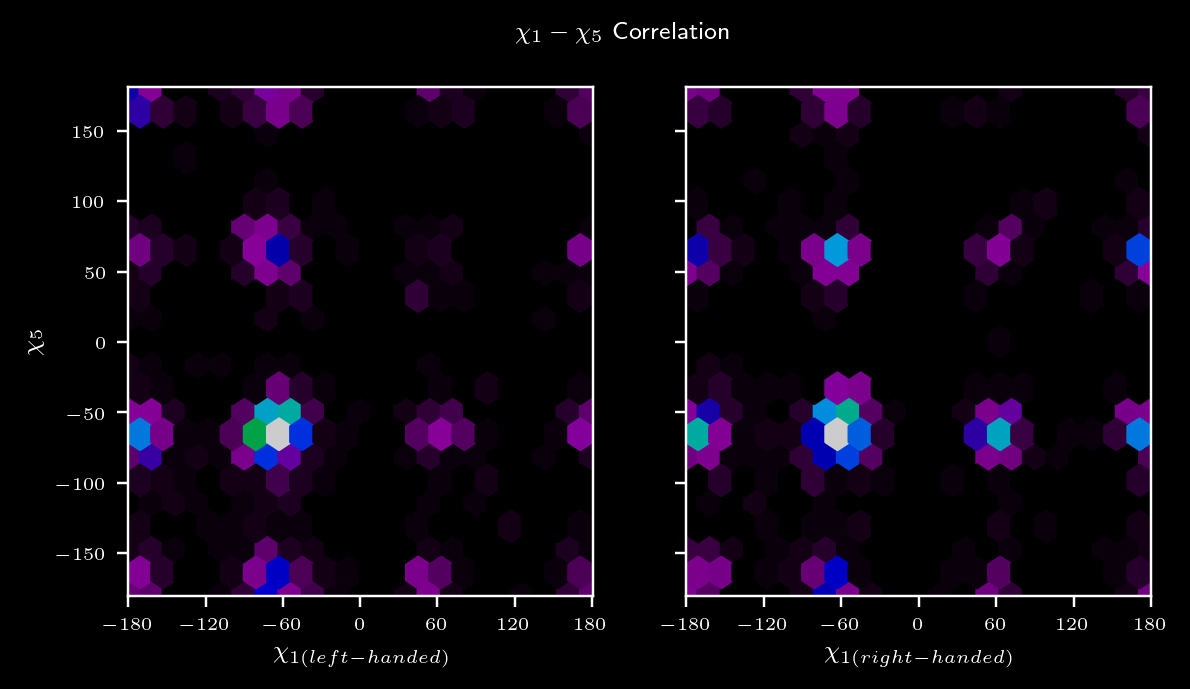

In [23]:
# !!!

x = SS_df_Left['chi1']
y = SS_df_Left['chi5']

x2 = SS_df_Right['chi1']
y2 = SS_df_Right['chi5']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

ax1, ax2 = fig.subplots(1, 2, sharey=True)

fig.suptitle(r'$\chi_{1} - \chi_{5}$ Correlation', fontsize=8)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)

ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{1 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{5}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(TORMIN-1, TORMAX+1)

ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{1 (right-handed)}$')

ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



The distributions look extremely similar for both the left-handed and right-handed populations. Let's look at Chi2 and Chi4 to see if this holds true.

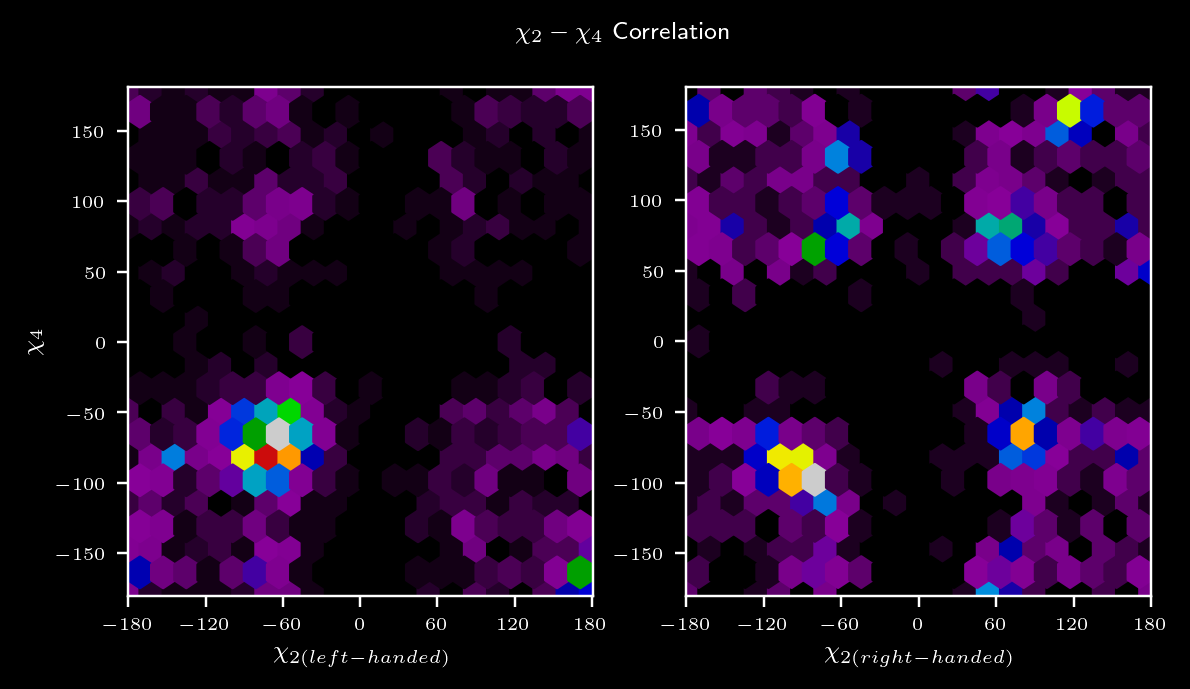

In [24]:
x = SS_df_Left['chi2']
y = SS_df_Left['chi4']

x2 = SS_df_Right['chi2']
y2 = SS_df_Right['chi4']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'$\chi_{2} - \chi_{4}$ Correlation', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{2 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{4}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{2 (right-handed)}$')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



The distributions for left/right show distinct differences. Both show the predicted minimum around -75 degrees, but the right-handed group shows a population of disfuldies in the +90 degree range.

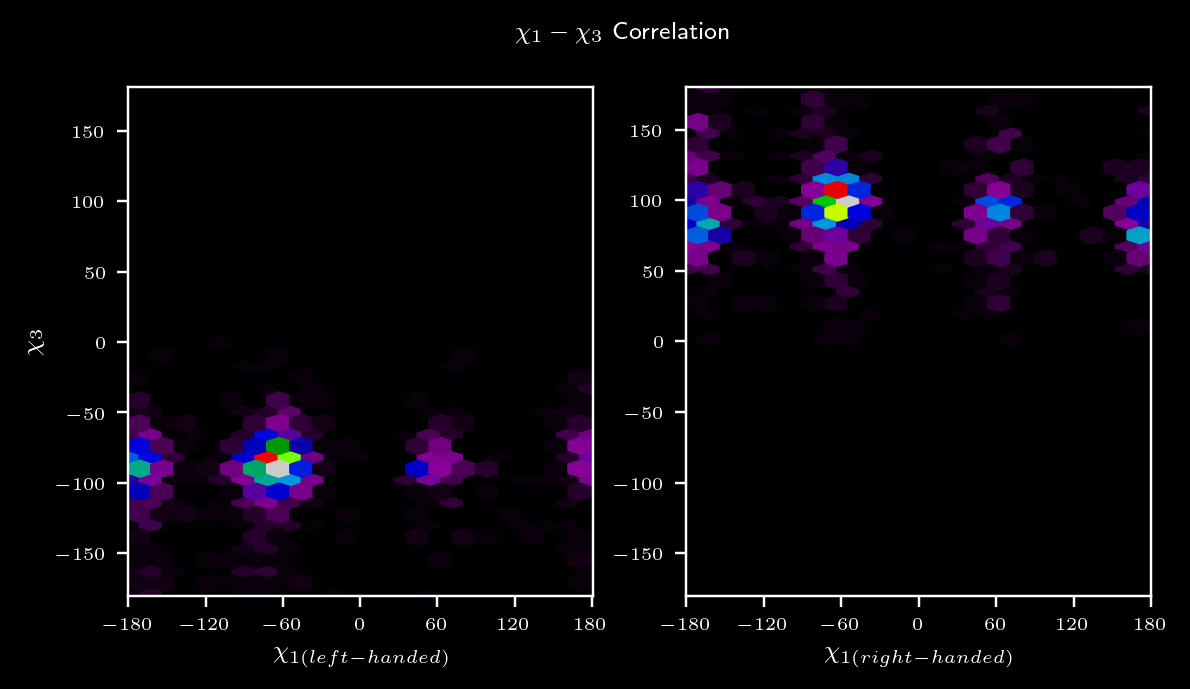

In [25]:
x = SS_df_Left['chi1']
y = SS_df_Left['chi3']

x2 = SS_df_Right['chi1']
y2 = SS_df_Right['chi3']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'$\chi_{1} - \chi_{3}$ Correlation', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{1 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{3}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{1 (right-handed)}$')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



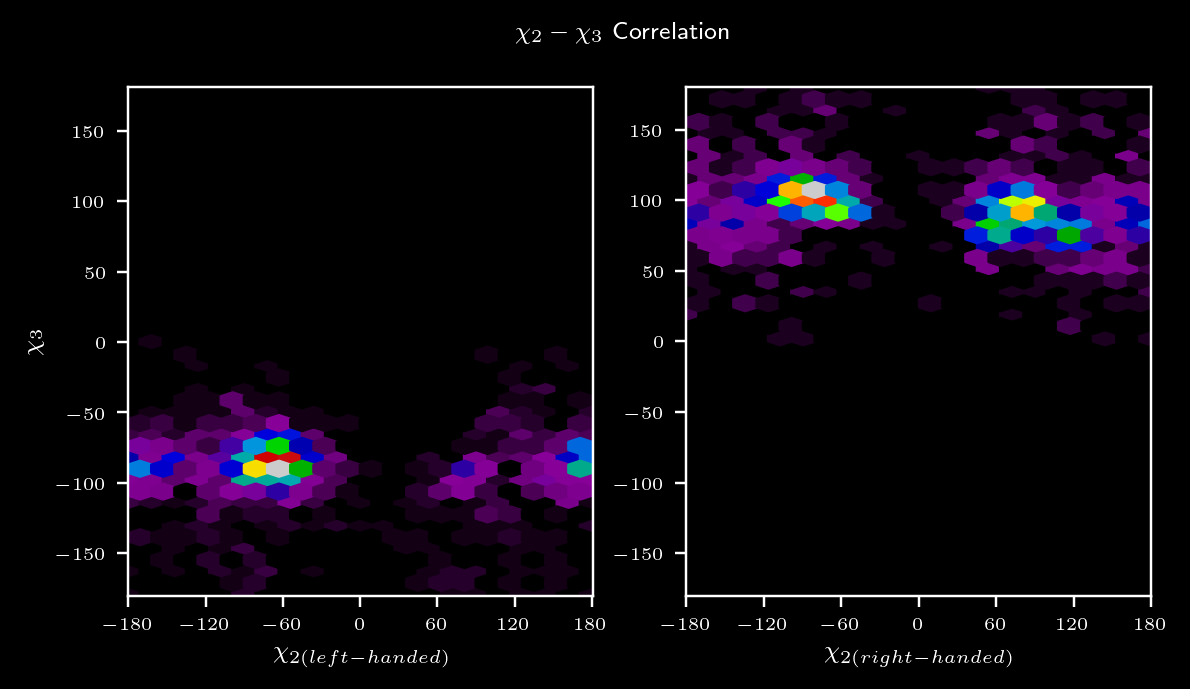

In [26]:
x = SS_df_Left['chi2']
y = SS_df_Left['chi3']

x2 = SS_df_Right['chi2']
y2 = SS_df_Right['chi3']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'$\chi_{2} - \chi_{3}$ Correlation', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{2 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{3}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{2 (right-handed)}$')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



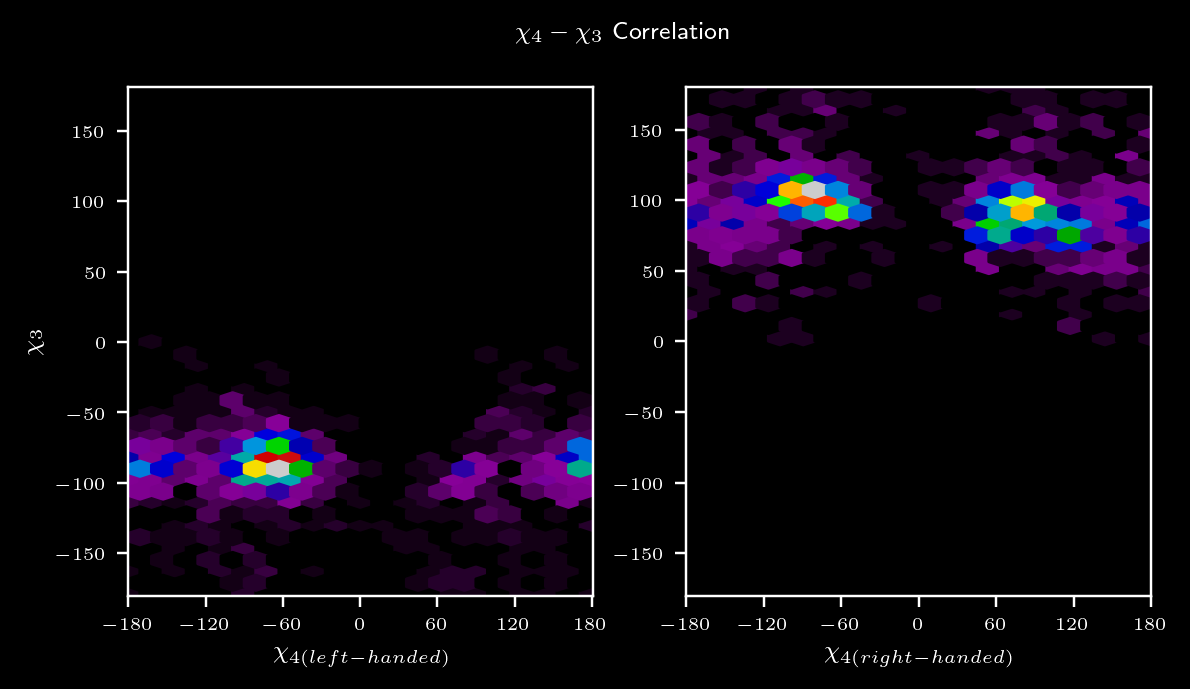

In [27]:
x = SS_df_Left['chi2']
y = SS_df_Left['chi3']

x2 = SS_df_Right['chi2']
y2 = SS_df_Right['chi3']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'$\chi_{4} - \chi_{3}$ Correlation', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{4 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{3}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{4 (right-handed)}$')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



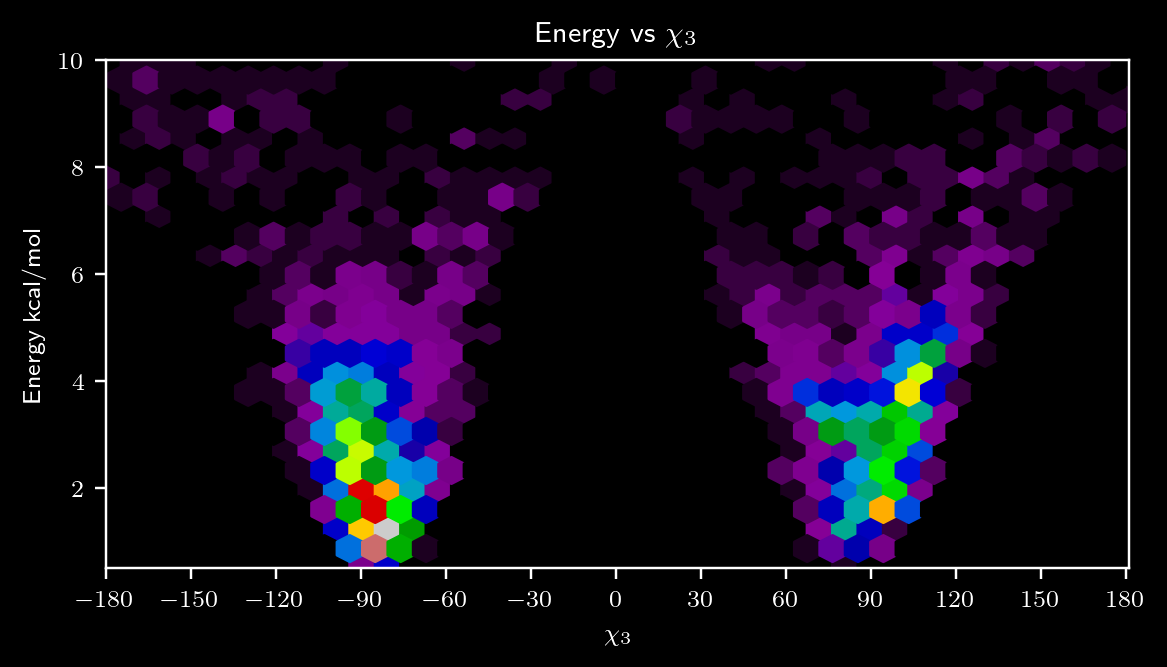

In [28]:
#

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)
ax1 = plt.subplot(111)

x = SS_df['chi3']
y = SS_df['energy']

ymax = 10.0
plt.hexbin(x, y, gridsize=40, cmap='nipy_spectral')
ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(y.min(), ymax)
ax1.set_xlabel(r'$\chi_{3}$')
ax1.set_ylabel(r'Energy kcal/mol')
ax1.set_title(r'Energy vs $\chi_{3}$')
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 30))

plt.show()


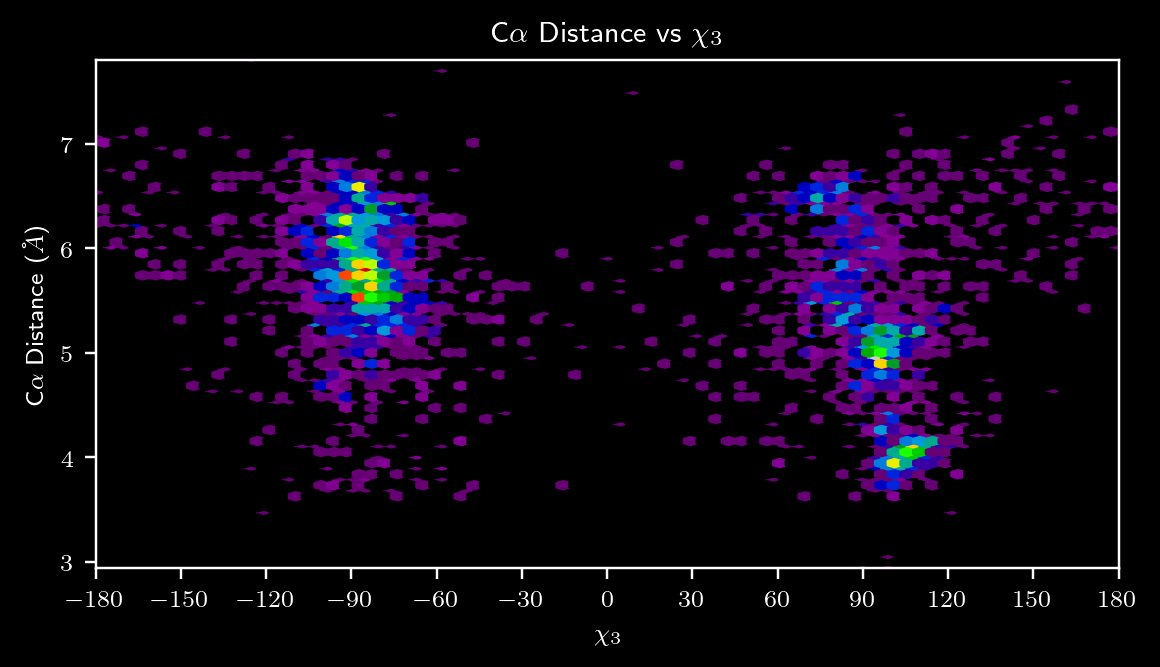

In [29]:
#
TORMAX = 180 # for left handed (Chi3 < 0)
fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)
ax1 = plt.subplot(111)

x = SS_df['chi3']
y = SS_df['ca_distance']

ymax = 8.0
plt.hexbin(x, y, gridsize=80, cmap='nipy_spectral')
ax1.set_xlim(TORMIN-1, TORMAX)
ax1.set_ylim(y.min(), y.max())
ax1.set_xlabel(r'$\chi_{3}$')
ax1.set_ylabel(r'C${\alpha}$ Distance ($\AA$)')
ax1.set_title(r'C${\alpha}$ Distance vs $\chi_{3}$')
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 30))

plt.show()


## Disulfide Clustering
If we could cluster the disulfides by their conformation we would be able to find conformational families; common structural motifs the recur within protein structures. The ```Scikit-Learn``` package offers a variety of clustering techniques. I explore some of them in the cells below.

### Gaussian Mixture

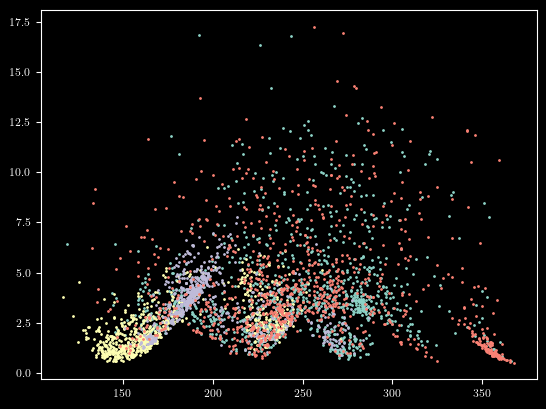

In [30]:
from sklearn.mixture import GaussianMixture
n_clusters = 4

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length', 'energy', 'ca_distance']

tor_df = SS_df[_cols]
tor_df.head(1)
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(tor_df)
cluster_labels = gmm_model.predict(tor_df)
X = pd.DataFrame(tor_df)
X['cluster'] = cluster_labels
for k in range(n_clusters):
    data = X[X['cluster'] == k]
    plt.scatter(data['torsion_length'], data['energy'], s=1)

plt.show()



In [ ]:
tor_df.head()

### Spectral Clustering

<AxesSubplot: title={'center': 'Spectral Clustering'}, xlabel='torsion_length', ylabel='energy'>

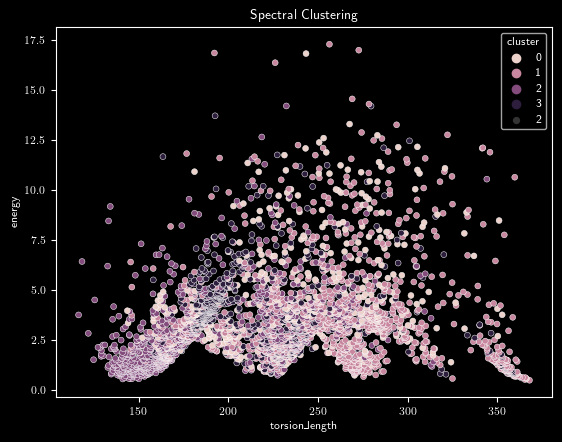

In [31]:
# takes over an hour for full dataset
from sklearn.cluster import SpectralClustering
import seaborn as sns

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length', 'energy']
#cols = ['ca_distance', 'chi3', 'energy', 'torsion_length']

# tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5']].copy()

tor_df = SS_df[_cols].copy()

X = tor_df
n_clusters = 4

scm_model = SpectralClustering(n_clusters=n_clusters, random_state=25,
                               n_neighbors=16, affinity='nearest_neighbors')
# takes 51 min with full dataset
X['cluster'] = scm_model.fit_predict(X)

fig, ax = plt.subplots()
ax.set(title='Spectral Clustering')
sns.scatterplot(y='energy', x='torsion_length', data=X, hue='cluster', ax=ax, size=2)


### Affinity Propagation

/Users/egs/miniforge3/envs/proteus/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[Text(0.5, 1.0, 'Affinity Propagation')]

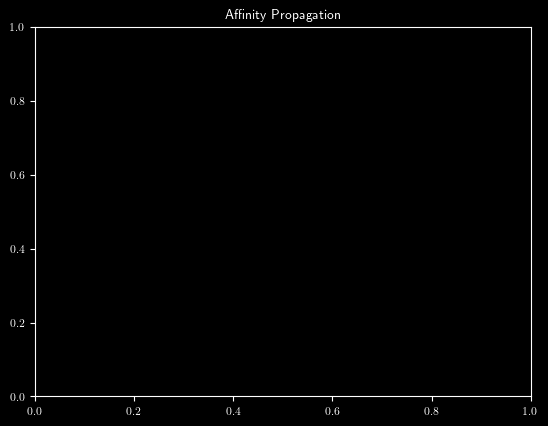

In [32]:
# takes over an hour for full dataset
from sklearn.cluster import AffinityPropagation
import seaborn as sns
n_clusters = 6
custom_palette = sns.color_palette("Dark2", n_clusters)


_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']
tor_df = SS_df[_cols].copy()

X = tor_df.copy()

aff_model = AffinityPropagation(max_iter=300, random_state=25)
# takes 51 min with full dataset
X['cluster'] = aff_model.fit_predict(X)

fig, ax = plt.subplots()
ax.set(title='Affinity Propagation')
#sns.scatterplot(x='chi1', y='chi5', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)



In [ ]:
fig, ax = plt.subplots()
ax.set(title='Affinity Propagation')
sns.scatterplot(x='chi1', y='chi5', data=X, hue='cluster', ax=ax, size=2)


### Agglomerative Clustering

In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4
custom_palette = sns.color_palette("Dark2", n_clusters)

tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']].copy()
X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X[['torsion_length']])

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi1', y='chi5', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)


In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering

n_clusters = 8
custom_palette = sns.color_palette("Dark2", n_clusters)


tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'energy', 'ca_distance']].copy()
X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X[['energy']])

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi1', y='energy', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)


In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering

n_clusters = 8
custom_palette = sns.color_palette("Dark2", n_clusters)


tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'ca_distance', 'torsion_length']].copy()
X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X)

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi1', y='chi2', data=X, hue='cluster', ax=ax, size=1, palette=custom_palette)


In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

n_clusters = 4
custom_palette = sns.color_palette("Dark2", n_clusters)


tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']].copy()
X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X)

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi1', y='chi3', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)


In [ ]:
# chatgpt output

from sklearn.cluster import AgglomerativeClustering

def cluster_by_family(data, n_clusters=3):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(data)
    return labels


In [ ]:
labels = {'value': 'Chi3', 'variable': 'Variable'}

x = SS_df['chi3']
y = SS_df['energy']
df = SS_df[['chi3', 'energy']].copy()

energy_hist = numpy.histogram2d(x, y=y, bins=360)
energy_hist = energy_hist

fig = px.histogram(df, labels=labels)

fig.show()

In [ ]:
cols = ['chi1', 'chi5']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
cols = ['chi2', 'chi4']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
px.histogram(SS_df['chi3'], labels=labels)

## Examining Disulfide Conformational Families
Richardson et al characterized two principal conformational families for Disulfide bonds, a *Left Handed Spiral* with dihedral angles around, -60, -90, -90, -90, -60 and a *Right Handed Hook* with dihedrals, -60, 120, 90, -50, -60. My research found another class, the *Left Handed Hook* with dihedrals x, x, x, x, x. We can easily examine the representative neighbors of these families using one of the nearest neighbor functions available through the ```Disulfide``` class.

In [ ]:

# retrieve the torsions dataframe
from proteusPy.Disulfide import Torsion_DF_Cols

_SSdf = PDB_SS.getTorsions()

# there are a few structures with bad SSBonds. Their
# CA distances are > 7.0. We remove them from consideration
# below

_near = _SSdf['ca_distance'] < 9.0

# entire database
SS_df = _SSdf[_near]

SS_df = SS_df[Torsion_DF_Cols].copy()
SS_df.describe()

sslist = PDB_SS.SSList
LHS_neighbors = sslist.nearest_neighbors(-60, -90, -90, -90, -60, 15.0)
LHS_neighbors.length

In [ ]:
LHS_neighbors.display_overlay(light=False)

In [ ]:
sslist = PDB_SS.SSList
RHH_neighbors = sslist.nearest_neighbors(-60, 120, 90, -50, -60, 30)
RHH_neighbors.length

In [ ]:
RHH_neighbors.display_overlay(light=False)

## Distribution of Backbone Dihedral Angles $\phi - \psi$
A protein's backbone conformation is defined by the dihdedral angles $\phi$ and $\psi$. The ```proteusPy.Disulfide.ExtractDisulfides()``` function computes these at time of Disulfide extraction.

In [ ]:
GRIDSIZE=40

x = SS_df['phi_prox']
y = SS_df['psi_prox']

x2 = SS_df['phi_dist']
y2 = SS_df['psi_dist']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'RCSB Disulfide Bond $\phi - \psi$ Dihedral Angles', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\phi$ Proximal')
ax1.set_ylabel(r'$\psi$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\phi$ Distal')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()


## Summary
Conformational analysis of 294,222 disulfide bonds in 36,362 proteins contained in the RCSB confirms the predominant conformational classes first described in my initial analysis:
- Left-Handed Spiral
- Right-Handed Hook
- Left-Handed Spiral
  

# Appendix
## Data Cleaning
* Parsing PDB files
* Extracting disulfides
* Removing redundant disulfides
* 

# Publications
* https://doi.org/10.1021/bi00368a023
* https://doi.org/10.1021/bi00368a024
* https://doi.org/10.1016/0092-8674(92)90140-8
* http://dx.doi.org/10.2174/092986708783330566